## Import Package

In [1]:
import re
import nltk
from nltk.draw.dispersion import dispersion_plot
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk import pos_tag

## Helper functions

We create a function to count the number of unique words in a text. We can use this fuction to compare the number of unique words before and after cleaning, with an expectation that after cleaning we have much less unique words.

In [2]:
def count_unique_words(text):
    # Counts the number of unique words in a given text.
    words = text.split() if isinstance(text, str) else text
    unique_words = set(words)
    return len(unique_words)

## Load two documents

In [3]:
with open("pandp.txt", "r", encoding= "utf-8") as f:
    pp = f.read()
pp[:100]

'\ufeffThe Project Gutenberg eBook of Pride and Prejudice\n    \nThis ebook is for the use of anyone anywher'

In [4]:
with open("sands.txt", "r", encoding= "utf-8") as f:
    ss = f.read()
ss[:100]

'\ufeffThe Project Gutenberg eBook of Sense and Sensibility\n    \nThis ebook is for the use of anyone anywh'

## 1. Text Cleaning 

We clean each document with the following steps:
- Extract the actual content of each book
- Remove extra white spaces
- Remove any character that is not alphabet (including punctuation and special characters)
- Convert all characters to lowercase
- Remove stopwords

### Extract the actual content of each book

In addition to the content, the original text also contains meta data, preface, content list, etc., which we do not need for comparison. Therefore, we will extract the content only.

To do this, we visually inspect the content of each document to know what characters each document starts and ends with. We then find the position of these starting and ending characters, and extract the content in between.

In [5]:
pp_start = re.search("It is a truth universally acknowledged",pp)
pp_start

<re.Match object; span=(35187, 35225), match='It is a truth universally acknowledged'>

In [6]:
pp_end = re.search("had been the means of uniting them.",pp)
pp_end

<re.Match object; span=(729325, 729360), match='had been the means of uniting them.'>

In [7]:
pp_content = pp[pp_start.start():pp_end.end()]

In [8]:
pp_content[:100]

'It is a truth universally acknowledged, that a single man in possession\nof a good fortune must be in'

In [9]:
pp_content[-100:]

'titude towards the persons who, by bringing\nher into Derbyshire, had been the means of uniting them.'

In [10]:
ss_start = re.search("The family of Dashwood had long been settled in Sussex.",ss)
ss_start

<re.Match object; span=(17796, 17851), match='The family of Dashwood had long been settled in S>

In [11]:
ss_end = re.search("between themselves, or producing coolness between their husbands.",ss)
ss_end

<re.Match object; span=(690803, 690868), match='between themselves, or producing coolness between>

In [12]:
ss_content = ss[ss_start.start():ss_end.end()]

In [13]:
ss_content[:100]

'The family of Dashwood had long been settled in Sussex. Their estate\nwas large, and their residence '

In [14]:
ss_content[-100:]

'ey could live without disagreement\nbetween themselves, or producing coolness between their husbands.'

### Remove extra white spaces

In [15]:
pp_content = re.sub('\s+', ' ', pp_content).strip()
pp_content[:1000]

'It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered as the rightful property of some one or other of their daughters. “My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do not you want to know who has taken it?” cried his wife, impatiently. “_You_ want to tell me, and I have no objection to hearing it.” [Illustration: “He came down to see the place” [_Copyright 1894 by George Allen._]] This was invitation enough. “Why, my dear, you must know, Mrs. Long says that Netherfield is taken by a young man of large fortune from t

In [16]:
ss_content = re.sub('\s+', ' ', ss_content).strip()
ss_content[:1000]

"The family of Dashwood had long been settled in Sussex. Their estate was large, and their residence was at Norland Park, in the centre of their property, where, for many generations, they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance. The late owner of this estate was a single man, who lived to a very advanced age, and who for many years of his life, had a constant companion and housekeeper in his sister. But her death, which happened ten years before his own, produced a great alteration in his home; for to supply her loss, he invited and received into his house the family of his nephew Mr. Henry Dashwood, the legal inheritor of the Norland estate, and the person to whom he intended to bequeath it. In the society of his nephew and niece, and their children, the old Gentleman's days were comfortably spent. His attachment to them all increased. The constant attention of Mr. and Mrs. Henry Dashwood to his wishes, which procee

### Remove non-alphabet characters

Non-alphabet characters, such as numbers, punctuations, special characters, etc., are not important for computing similarities between two documents with cosine similarity. Therefore, we remove them from the content of both documents using regex.

In [17]:
pp_content = re.sub(r'[^a-zA-Z\s]', '', pp_content)
pp_content[:1000]

'It is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife However little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered as the rightful property of some one or other of their daughters My dear Mr Bennet said his lady to him one day have you heard that Netherfield Park is let at last Mr Bennet replied that he had not But it is returned she for Mrs Long has just been here and she told me all about it Mr Bennet made no answer Do not you want to know who has taken it cried his wife impatiently You want to tell me and I have no objection to hearing it Illustration He came down to see the place Copyright  by George Allen This was invitation enough Why my dear you must know Mrs Long says that Netherfield is taken by a young man of large fortune from the north of England that he came down on Monday in a chai

In [18]:
ss_content = re.sub(r'[^a-zA-Z\s]', '', ss_content)
ss_content[:1000]

'The family of Dashwood had long been settled in Sussex Their estate was large and their residence was at Norland Park in the centre of their property where for many generations they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance The late owner of this estate was a single man who lived to a very advanced age and who for many years of his life had a constant companion and housekeeper in his sister But her death which happened ten years before his own produced a great alteration in his home for to supply her loss he invited and received into his house the family of his nephew Mr Henry Dashwood the legal inheritor of the Norland estate and the person to whom he intended to bequeath it In the society of his nephew and niece and their children the old Gentlemans days were comfortably spent His attachment to them all increased The constant attention of Mr and Mrs Henry Dashwood to his wishes which proceeded not merely from interes

### Convert to lowercase

We convert all characters to lower case since it does not change the content of the text.

In [19]:
pp_content = pp_content.lower()
pp_content[:1000]

'it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife however little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered as the rightful property of some one or other of their daughters my dear mr bennet said his lady to him one day have you heard that netherfield park is let at last mr bennet replied that he had not but it is returned she for mrs long has just been here and she told me all about it mr bennet made no answer do not you want to know who has taken it cried his wife impatiently you want to tell me and i have no objection to hearing it illustration he came down to see the place copyright  by george allen this was invitation enough why my dear you must know mrs long says that netherfield is taken by a young man of large fortune from the north of england that he came down on monday in a chai

In [20]:
ss_content = ss_content.lower()
ss_content[:1000]

'the family of dashwood had long been settled in sussex their estate was large and their residence was at norland park in the centre of their property where for many generations they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance the late owner of this estate was a single man who lived to a very advanced age and who for many years of his life had a constant companion and housekeeper in his sister but her death which happened ten years before his own produced a great alteration in his home for to supply her loss he invited and received into his house the family of his nephew mr henry dashwood the legal inheritor of the norland estate and the person to whom he intended to bequeath it in the society of his nephew and niece and their children the old gentlemans days were comfortably spent his attachment to them all increased the constant attention of mr and mrs henry dashwood to his wishes which proceeded not merely from interes

### Remove stop words

In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
pp_content_tokens = pp_content.split() # split the text into words for stopwords removal
pp_content_tokens = [word for word in pp_content_tokens if word not in stop_words] # remove stopwords
pp_content = ' '.join(pp_content_tokens) # join the words back into a single string
pp_content[:100]

'truth universally acknowledged single man possession good fortune must want wife however little know'

In [23]:
ss_content_tokens = ss_content.split() # split the text into words for stopwords removal
ss_content_tokens = [word for word in ss_content_tokens if word not in stop_words] # remove stopwords
ss_content = ' '.join(ss_content_tokens) # join the words back into a single string
ss_content[:1000]

'family dashwood long settled sussex estate large residence norland park centre property many generations lived respectable manner engage general good opinion surrounding acquaintance late owner estate single man lived advanced age many years life constant companion housekeeper sister death happened ten years produced great alteration home supply loss invited received house family nephew mr henry dashwood legal inheritor norland estate person intended bequeath society nephew niece children old gentlemans days comfortably spent attachment increased constant attention mr mrs henry dashwood wishes proceeded merely interest goodness heart gave every degree solid comfort age could receive cheerfulness children added relish existence former marriage mr henry dashwood one son present lady three daughters son steady respectable young man amply provided fortune mother large half devolved coming age marriage likewise happened soon afterwards added wealth therefore succession norland estate reall

### Compare number of unique words before and after clean

In [24]:
print (f"pandp before cleaning: {count_unique_words(pp)}, after cleaning: {count_unique_words(pp_content)}")
print (f"sands before cleaning: {count_unique_words(ss)}, after cleaning: {count_unique_words(ss_content)}")

pandp before cleaning: 14705, after cleaning: 6603
sands before cleaning: 14247, after cleaning: 6985


## 2. Tokenization

We use the word tokenizer from nltk for tokenization

In [25]:
pandp_content_tokens = word_tokenize(pp_content)
pandp_content_tokens

['truth',
 'universally',
 'acknowledged',
 'single',
 'man',
 'possession',
 'good',
 'fortune',
 'must',
 'want',
 'wife',
 'however',
 'little',
 'known',
 'feelings',
 'views',
 'man',
 'may',
 'first',
 'entering',
 'neighbourhood',
 'truth',
 'well',
 'fixed',
 'minds',
 'surrounding',
 'families',
 'considered',
 'rightful',
 'property',
 'one',
 'daughters',
 'dear',
 'mr',
 'bennet',
 'said',
 'lady',
 'one',
 'day',
 'heard',
 'netherfield',
 'park',
 'let',
 'last',
 'mr',
 'bennet',
 'replied',
 'returned',
 'mrs',
 'long',
 'told',
 'mr',
 'bennet',
 'made',
 'answer',
 'want',
 'know',
 'taken',
 'cried',
 'wife',
 'impatiently',
 'want',
 'tell',
 'objection',
 'hearing',
 'illustration',
 'came',
 'see',
 'place',
 'copyright',
 'george',
 'allen',
 'invitation',
 'enough',
 'dear',
 'must',
 'know',
 'mrs',
 'long',
 'says',
 'netherfield',
 'taken',
 'young',
 'man',
 'large',
 'fortune',
 'north',
 'england',
 'came',
 'monday',
 'chaise',
 'four',
 'see',
 'place',


In [26]:
print (f"number of tokens in pandp: {len(pandp_content_tokens)}")

number of tokens in pandp: 55535


In [27]:
sands_content_tokens = word_tokenize(ss_content)
sands_content_tokens

['family',
 'dashwood',
 'long',
 'settled',
 'sussex',
 'estate',
 'large',
 'residence',
 'norland',
 'park',
 'centre',
 'property',
 'many',
 'generations',
 'lived',
 'respectable',
 'manner',
 'engage',
 'general',
 'good',
 'opinion',
 'surrounding',
 'acquaintance',
 'late',
 'owner',
 'estate',
 'single',
 'man',
 'lived',
 'advanced',
 'age',
 'many',
 'years',
 'life',
 'constant',
 'companion',
 'housekeeper',
 'sister',
 'death',
 'happened',
 'ten',
 'years',
 'produced',
 'great',
 'alteration',
 'home',
 'supply',
 'loss',
 'invited',
 'received',
 'house',
 'family',
 'nephew',
 'mr',
 'henry',
 'dashwood',
 'legal',
 'inheritor',
 'norland',
 'estate',
 'person',
 'intended',
 'bequeath',
 'society',
 'nephew',
 'niece',
 'children',
 'old',
 'gentlemans',
 'days',
 'comfortably',
 'spent',
 'attachment',
 'increased',
 'constant',
 'attention',
 'mr',
 'mrs',
 'henry',
 'dashwood',
 'wishes',
 'proceeded',
 'merely',
 'interest',
 'goodness',
 'heart',
 'gave',
 'eve

In [28]:
print (f"number of tokens in sands: {len(sands_content_tokens)}")

number of tokens in sands: 54149


## 3. Exploration

We choose two summarization tasks: Word Clouds and Dispersion Plot. Word Clouds allow us to visually see what words are the most dominant in each document, while Dispersion Plot shows the distribution of a word througout the document.

### Word Clouds

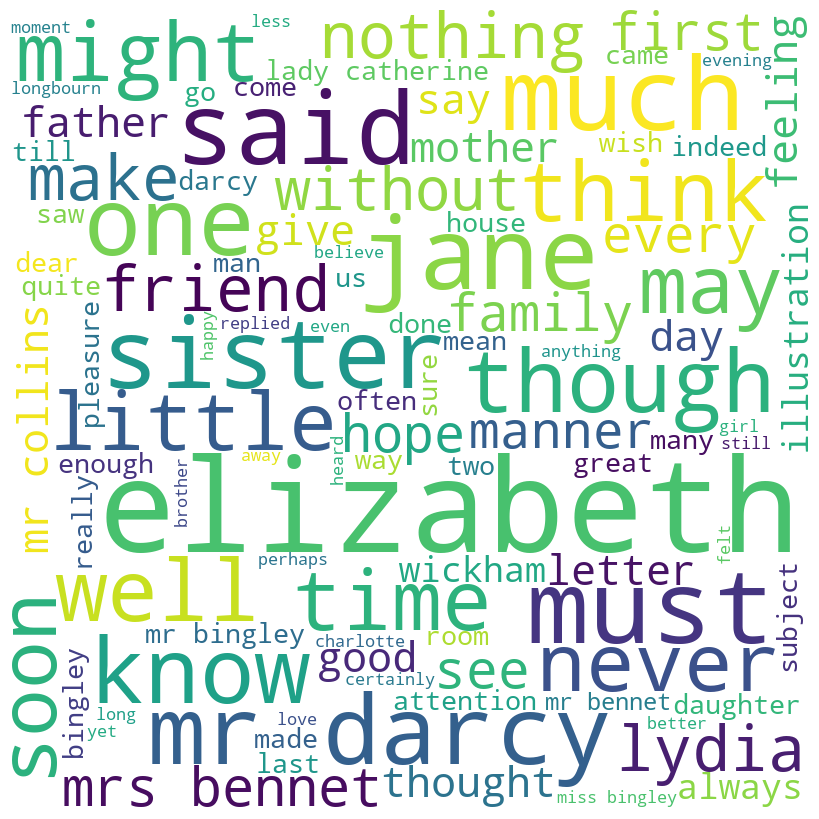

In [29]:
wordcloud = WordCloud(width = 800, height = 800, max_words=100,
    background_color ='white',
    min_font_size = 10
).generate(pp_content)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

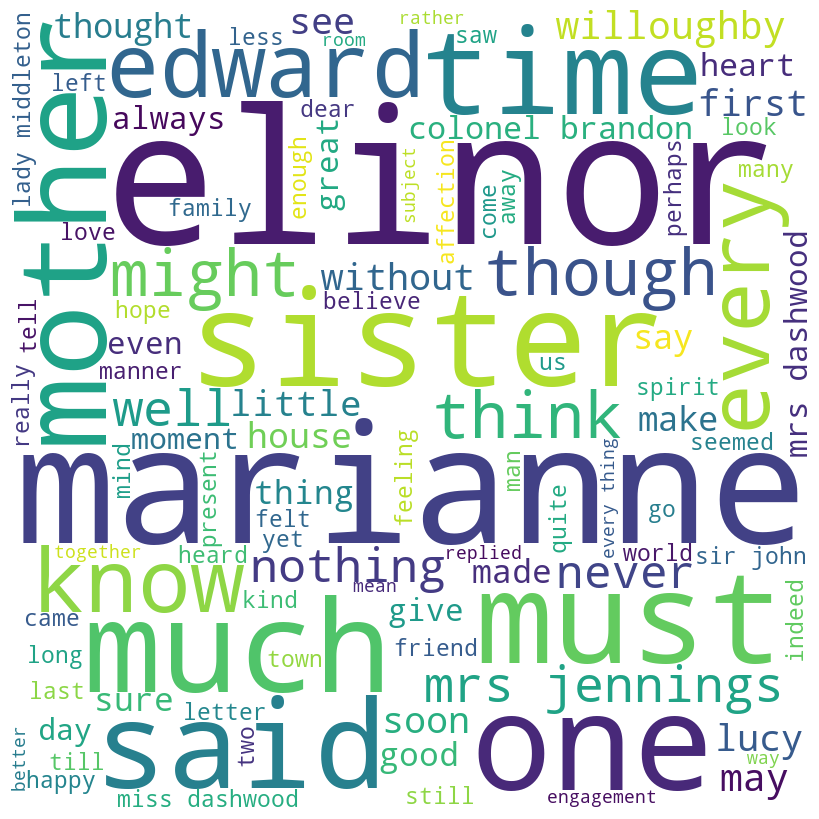

In [30]:
wordcloud = WordCloud(width = 800, height = 800, max_words=100,
    background_color ='white',
    min_font_size = 10
).generate(ss_content)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Dispersion Plot

We plot the dispersion of 5 common and seemingly interesting for each document.

<Axes: title={'center': 'PandP Dispersion Plot'}, xlabel='Word Offset'>

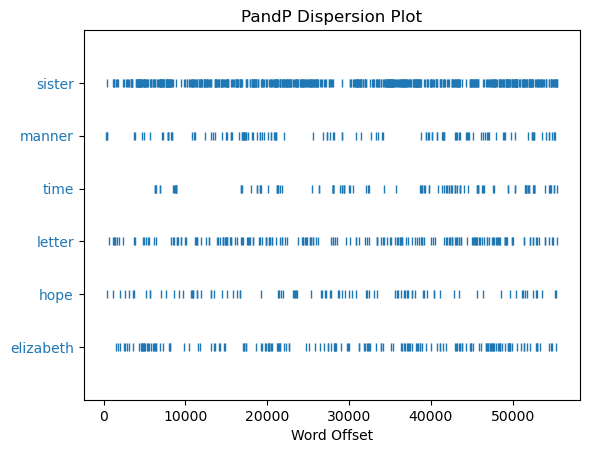

In [31]:
dispersion_plot(pp_content_tokens, [
    "elizabeth",
    "hope",
    "letter",
    "time",
    "manner",
    "sister"
], title="PandP Dispersion Plot")

<Axes: title={'center': 'SandS Dispersion Plot'}, xlabel='Word Offset'>

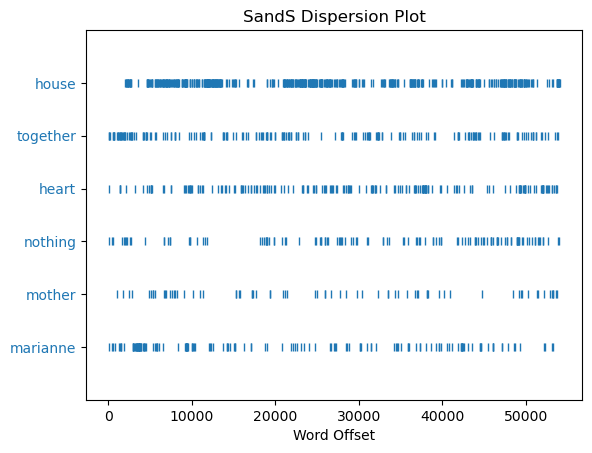

In [32]:
dispersion_plot(ss_content_tokens, [
    "marianne",
    "mother",
    "nothing",
    "heart",
    "together",
    "house"
], title="SandS Dispersion Plot")

### Summarization of two books

Based on the word cloud and the dispersion plot of `Pride and Prejudice`, we can draw the following summaries about this novel:
- Elizabeth, Mr. Darcy, Jane, and Mrs. Bennet are the main characters.
- The dominant words such as `sister`, `friend`, and `father` suggest the main themes of the book are family, manners, and relationships.
- The presence of words like `friend`, `house`, and `Longbourn` (likely a place) suggests the importance of social settings and interactions.

Based on the word cloud and the dispersion plot of `Sense and Sensibility`, we can draw the following summaries about this novel:
- The names `Marianne`, `Elinor`, `Edward`, and `Willoughby` suggest these are key characters.
- The prominence of words like `mother`, `sister`, `heart`, and `affection` indicates a focus on familial and romantic love.
- The repetition of `said` and `replied` hints at the importance of dialogue and communication.
- The contrast of `happy` with `little` and `much` might reflect the themes of wealth, social status, and the pursuit of happiness despite societal constraints.

# 4. Feature Engineering

We perform 3 feature engineering tasks: POS, Lemmatization, and N-grams. We perform POS+Lemmatization together because Lemmatization requires POS to be work precisely. POS+Lemmatization and N-grams lead to two different vectorization of each document, which we refer to as Feature Engineering A and Feature Engineering B.

### POS+Lemmatization

Lemmatization helps standardize text by reducing each word to its root form. To work properly, Lemmatization needs to know the form of the word, which is output by POS.

In [33]:
pos_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
}
tagged_tokens = pos_tag(pp_content_tokens)

lemmatizer = WordNetLemmatizer()
lemmatized_pp_content_tokens = [
    lemmatizer.lemmatize(word, pos=pos_map.get(tag[0], wordnet.NOUN)) for word, tag in tagged_tokens
]

In [34]:
pos_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
}
tagged_tokens = pos_tag(ss_content_tokens)

lemmatizer = WordNetLemmatizer()
lemmatized_ss_content_tokens = [
    lemmatizer.lemmatize(word, pos=pos_map.get(tag[0], wordnet.NOUN)) for word, tag in tagged_tokens
]

### N-grams

N-grams helps retain the sequential order of the words better instead of treating each word as an individual and independent token. We use bi-grams (N=2).

In [35]:
n = 2 # bi-grams
pp_ngrams = []

for i in range(len(pp_content_tokens) - n + 1):
    # select n words starting from the current index
    ngram = pp_content_tokens[i:i+n]
    
    # join the words to create a single n-gram string
    ngram_string = '-'.join(ngram)
    
    pp_ngrams.append(ngram_string)
print (pp_ngrams)
print (count_unique_words(pp_ngrams))

['truth-universally', 'universally-acknowledged', 'acknowledged-single', 'single-man', 'man-possession', 'possession-good', 'good-fortune', 'fortune-must', 'must-want', 'want-wife', 'wife-however', 'however-little', 'little-known', 'known-feelings', 'feelings-views', 'views-man', 'man-may', 'may-first', 'first-entering', 'entering-neighbourhood', 'neighbourhood-truth', 'truth-well', 'well-fixed', 'fixed-minds', 'minds-surrounding', 'surrounding-families', 'families-considered', 'considered-rightful', 'rightful-property', 'property-one', 'one-daughters', 'daughters-dear', 'dear-mr', 'mr-bennet', 'bennet-said', 'said-lady', 'lady-one', 'one-day', 'day-heard', 'heard-netherfield', 'netherfield-park', 'park-let', 'let-last', 'last-mr', 'mr-bennet', 'bennet-replied', 'replied-returned', 'returned-mrs', 'mrs-long', 'long-told', 'told-mr', 'mr-bennet', 'bennet-made', 'made-answer', 'answer-want', 'want-know', 'know-taken', 'taken-cried', 'cried-wife', 'wife-impatiently', 'impatiently-want', '

In [36]:
n = 2 # bi-grams
ss_ngrams = []

for i in range(len(ss_content_tokens) - n + 1):
    # select n words starting from the current index
    ngram = ss_content_tokens[i:i+n]
    
    # join the words to create a single n-gram string
    ngram_string = '-'.join(ngram)
    
    ss_ngrams.append(ngram_string)
print (ss_ngrams)
print (count_unique_words(ss_ngrams))

['family-dashwood', 'dashwood-long', 'long-settled', 'settled-sussex', 'sussex-estate', 'estate-large', 'large-residence', 'residence-norland', 'norland-park', 'park-centre', 'centre-property', 'property-many', 'many-generations', 'generations-lived', 'lived-respectable', 'respectable-manner', 'manner-engage', 'engage-general', 'general-good', 'good-opinion', 'opinion-surrounding', 'surrounding-acquaintance', 'acquaintance-late', 'late-owner', 'owner-estate', 'estate-single', 'single-man', 'man-lived', 'lived-advanced', 'advanced-age', 'age-many', 'many-years', 'years-life', 'life-constant', 'constant-companion', 'companion-housekeeper', 'housekeeper-sister', 'sister-death', 'death-happened', 'happened-ten', 'ten-years', 'years-produced', 'produced-great', 'great-alteration', 'alteration-home', 'home-supply', 'supply-loss', 'loss-invited', 'invited-received', 'received-house', 'house-family', 'family-nephew', 'nephew-mr', 'mr-henry', 'henry-dashwood', 'dashwood-legal', 'legal-inheritor

# 5. Vectorization

After feature engineering, we have two sets of features for each document, one corresponding to lemmatization (A) and the other corresponding to n-grams (B). We vectorize each feature set with tfid, using the built-in class from sklearn.

### Vectorization for feature engineering A (with lemmatization)

In [37]:
tfidf = TfidfVectorizer()
tfidfmatrix_feature_a = tfidf.fit_transform([
    ' '.join(lemmatized_pp_content_tokens),
    ' '.join(lemmatized_ss_content_tokens)
])
tfidfmatrix_feature_a.shape

(2, 7698)

### Vectorization for feature engineering B (with ngrams)

In [38]:
tfidf = TfidfVectorizer()
tfidfmatrix_feature_b = tfidf.fit_transform([
    ' '.join(pp_ngrams),
    ' '.join(ss_ngrams)
])
tfidfmatrix_feature_b.shape

(2, 9390)

# 6. Comparison

We then compute the similarity between feature engineering A of 2 documents, and feature engineering B of 2 documents.

In [39]:
consine_sim_feature_a = cosine_similarity(tfidfmatrix_feature_a[0], tfidfmatrix_feature_a[1])
consine_sim_feature_a

array([[0.69651372]])

The cosine similarity between two documents using feature engineering A (POS+lemmatization) is 0.70.

In [40]:
consine_sim_feature_b = cosine_similarity(tfidfmatrix_feature_b[0], tfidfmatrix_feature_b[1])
consine_sim_feature_b

array([[0.62867521]])

The cosine similarity between two documents using feature engineering B (bi-grams) is 0.63, which is close to the cosine similarity using feature engineering A.

## Insights and Conclusion

Insights about the two books:
- High similarity between the two novels (0.70 and 0.63).
- Shared vocabulary and themes: reflective of Austen's focus on morality, courtship, and the social standing of women.
- Shows consistency in Austen's writing styles across works.

Insights about the two feature engineering techniques:
1. POS+Lemmatization:
- Focus on the meaning of words.
- More effective for understanding thematic similarities such as shared themes, vocabulary, and overarching narrative elements.

2. N-grams
- Take into account the context in which words appear.
- Provide richer insights about the narrative style, sentence construction, and the specific use of language.

In conclusion, if you want to focus on the main themes and ideas, **lemmatization** works better. If you are interested in the writing style and how words are used together, **n-grams** are better.